# SVM Analysis

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


## Step 1: Import the necessary Libraries
we will need to import libraries that allow for data analysis and data visualization to get acclimated to the dataset. We will be using pandas, numpy, matplotlib and seaborn to conduct this. Data Exploration libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings("ignore",'detected Windows; aliasing chunkize to chunkize_serial')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from collections import Counter

## Step 2: Read in the dataset.
We will use the pandas .read_csv() method to read in the dataset. Then we will use the. head() method to observe the first few rows of the data, to understand the information better. In our case, the feature(column) headers tell us pretty little. This is fine because we are merely trying to gain insight via classifying new data points by referencing it’s neighboring elements.

## 1.1 Reading Data

In [2]:
project_data = pd.read_csv("C:\\VipinML\\Assignment 2\\Assignments_DonorsChoose_2018\\train_data.csv")
resource_data = pd.read_csv("C:\\VipinML\Assignment 2\\Assignments_DonorsChoose_2018\\resources.csv")
#Limit the data for testing purpose since processing takes few hours for full set..

project_data = project_data.head(2000)
resource_data = resource_data.head (2000)

resource_data.head(1)


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.0


In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (2000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]
#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]
project_data.head(1)



,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
473,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,Mrs.,GA,2016-04-27 00:53:00,Grades PreK-2,Applied Learning,Early Development,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1


## 1.2 preprocessing of `project_subject_categories`

In [5]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [6]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))



In [7]:
teacher_cat = list(project_data['teacher_prefix'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in teacher_cat:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
    temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
    temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

project_data.drop(['teacher_prefix'], axis=1, inplace=True)
project_data['teacher_prefix'] = sub_cat_list
    
from collections import Counter
my_counter = Counter()
for word in project_data['teacher_prefix'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_teacher_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 Text preprocessing

In [8]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)



In [9]:
#clean project_grade_category
project_data["project_grade_category"] = \
project_data.apply(lambda x: (x['project_grade_category'].replace(' ', '_')), axis=1)
project_data["project_grade_category"] = \
project_data.apply(lambda x: (x['project_grade_category'].replace('-', '_')), axis=1)

In [10]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,teacher_prefix,essay
473,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,GA,2016-04-27 00:53:00,Grades_PreK_2,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1,AppliedLearning,EarlyDevelopment,EarlyDevelopment,I recently read an article about giving studen...


In [11]:
#### 1.4.2.3 Using Pretrained Models: TFIDF weighted W2V

In [12]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
sent = decontracted(project_data['essay'].values[500])
print(sent[1:200])
print("="*100)

s a teacher at a Title 1 school, many of my students receive free or reduced price lunch and have extremely limited resources.  Some face challenges daily that many adults never have to experience. M


In [14]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent[1:200])
print(sent[1:200])

s a teacher at a Title 1 school, many of my students receive free or reduced price lunch and have extremely limited resources.  Some face challenges daily that many adults never have to experience. M
s a teacher at a Title 1 school, many of my students receive free or reduced price lunch and have extremely limited resources.  Some face challenges daily that many adults never have to experience. M


In [15]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent[1:200])

s a teacher at a Title 1 school many of my students receive free or reduced price lunch and have extremely limited resources Some face challenges daily that many adults never have to experience My st


In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

### 1.4.3 Merging price with project_data

In [17]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')
print (price_data[1:3])
project_data.head(1)

        id   price  quantity
1  p003483   81.28        40
2  p006068  557.98        16


,Unnamed: 0,id,teacher_id,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,teacher_prefix,essay,price,quantity
0,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,GA,2016-04-27 00:53:00,Grades_PreK_2,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1,AppliedLearning,EarlyDevelopment,EarlyDevelopment,I recently read an article about giving studen...,NaN,NaN


### 1.4.3.1 Merge Project Title Count with project_data

In [18]:
# Add count (total number of words) in Project Title in each row.

project_title_count = project_data['project_title'].str.split().str.len()
project_data['project_title_count'] = project_title_count
project_data.head(1)

,Unnamed: 0,id,teacher_id,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,...,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,teacher_prefix,essay,price,quantity,project_title_count
0,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,GA,2016-04-27 00:53:00,Grades_PreK_2,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,...,My students need flexible seating in the class...,2,1,AppliedLearning,EarlyDevelopment,EarlyDevelopment,I recently read an article about giving studen...,NaN,NaN,5


### 1.4.3.2 Essay count of words for each row and  merge with project_data

In [19]:
# Add count (total number of words) in essay in each row.

essay_count = project_data['essay'].str.split().str.len()
project_data['essay_count'] = essay_count
project_data.head(1)

,Unnamed: 0,id,teacher_id,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,...,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,teacher_prefix,essay,price,quantity,project_title_count,essay_count
0,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,GA,2016-04-27 00:53:00,Grades_PreK_2,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,...,2,1,AppliedLearning,EarlyDevelopment,EarlyDevelopment,I recently read an article about giving studen...,NaN,NaN,5,225


In [20]:
#Convert NaN value to mean of the column
project_data.fillna(project_data.mean(), inplace=True)
project_data.head(1)

,Unnamed: 0,id,teacher_id,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,...,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,teacher_prefix,essay,price,quantity,project_title_count,essay_count
0,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,GA,2016-04-27 00:53:00,Grades_PreK_2,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,...,2,1,AppliedLearning,EarlyDevelopment,EarlyDevelopment,I recently read an article about giving studen...,103.01,4.0,5,225


## Splitting data into Train and cross validation(or test): Stratified Sampling

In [21]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)


In [22]:
catogories_essay = list(project_data['essay'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_essay_list = []
for i in catogories_essay:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_essay_list.append(temp.strip())
    
project_data['clean_essay'] = cat_essay_list

from collections import Counter
my_counter = Counter()
for word in project_data['clean_essay'].values:
    my_counter.update(word.split())

cat_essay_dict = dict(my_counter)
sorted_cat_essay_dict = dict(sorted(cat_essay_dict.items(), key=lambda kv: kv[1]))



In [23]:
catogories_title = list(project_data['project_title'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
project_title_list = []
for i in catogories_title:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    project_title_list.append(temp.strip())

#project_data.drop('project_title', axis=1, inplace=True)
#project_data['project_title'] = project_title_list

from collections import Counter
my_counter = Counter()
for word in project_data['project_title'].values:
    my_counter.update(word.split())

project_title_dict = dict(my_counter)
sorted_project_title_dict = dict(sorted(project_title_dict.items(), key=lambda kv: kv[1]))

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
X_train_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    X_train_preprocessed_essays.append(sent.lower().strip())
   # print (X_train_preprocessed_essays)
    

100%|██████████| 1340/1340 [00:00<00:00, 1542.95it/s]


In [25]:
# Combining all the above stundents 
from tqdm import tqdm
X_test_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    X_test_preprocessed_essays.append(sent.lower().strip())
   # print (X_test_preprocessed_essays)
    

100%|██████████| 660/660 [00:00<00:00, 1460.60it/s]


## Step 3: Standardize (normalize) the data scale to prep for Logistic regression.
Because the distance between pairs of points plays a critical part on the classification, it is necessary to normalize the data This will generate an array of values. 

### 1.4.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

### Vectorization of clean_categories for X_train,X_test

In [26]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000,lowercase=False, binary=True)
X_train_categories_one_hot = vectorizer.fit_transform(X_train['clean_categories'].values)
X_test_categories_one_hot = vectorizer.transform(X_test['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix X_train_categories_one_hot  after one hot encodig ",X_train_categories_one_hot.shape)
print("Shape of matrix X_test_categories_one_hot after one hot encodig ",X_test_categories_one_hot.shape)


['AppliedLearning', 'AppliedLearning Literacy_Language', 'AppliedLearning Music_Arts', 'AppliedLearning SpecialNeeds', 'Care_Hunger', 'Health_Sports', 'Health_Sports SpecialNeeds', 'History_Civics', 'History_Civics Literacy_Language', 'Literacy_Language', 'Literacy_Language History_Civics', 'Literacy_Language Math_Science', 'Literacy_Language Music_Arts', 'Literacy_Language SpecialNeeds', 'Math_Science', 'Math_Science AppliedLearning', 'Math_Science History_Civics', 'Math_Science Literacy_Language', 'Math_Science Music_Arts', 'Math_Science SpecialNeeds', 'Music_Arts', 'SpecialNeeds', 'Warmth', 'Warmth Care_Hunger']
Shape of matrix X_train_categories_one_hot  after one hot encodig  (1340, 24)
Shape of matrix X_test_categories_one_hot after one hot encodig  (660, 24)


In [27]:
### Vectorization of project_grade_category for X_train,X_test

In [28]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000, lowercase=False, binary=True)
X_train_project_grade_category_one_hot = vectorizer.fit_transform(X_train['project_grade_category'].values)
X_test_project_grade_category_one_hot = vectorizer.transform(X_test['project_grade_category'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix X_train_project_grade_category_one_hot  after one hot encodig ",X_train_project_grade_category_one_hot.shape)
print("Shape of matrix X_test_project_grade_category_one_hot after one hot encodig ",X_test_project_grade_category_one_hot.shape)


['Grades_3_5', 'Grades_6_8', 'Grades_9_12', 'Grades_PreK_2']
Shape of matrix X_train_project_grade_category_one_hot  after one hot encodig  (1340, 4)
Shape of matrix X_test_project_grade_category_one_hot after one hot encodig  (660, 4)


In [29]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000, lowercase=False, binary=True)
X_train_school_state_one_hot = vectorizer.fit_transform(X_train['school_state'].values)
X_test_school_state_one_hot = vectorizer.transform(X_test['school_state'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix X_train_school_state_one_hot  after one hot encodig ",X_train_school_state_one_hot.shape)
print("Shape of matrix X_test_school_state_one_hot after one hot encodig ",X_test_school_state_one_hot.shape)


['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL', 'IN', 'KY', 'LA', 'MA', 'MD', 'MI', 'MO', 'MS', 'NC', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI']
Shape of matrix X_train_school_state_one_hot  after one hot encodig  (1340, 33)
Shape of matrix X_test_school_state_one_hot after one hot encodig  (660, 33)


### Vectorization of clean_subcategories for X_train,X_test

In [30]:
# we use count vectorizer to convert the values into one 
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000,vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
X_train_sub_categories_one_hot = vectorizer.fit_transform(X_train['clean_subcategories'].values)
X_test_sub_categories_one_hot = vectorizer.transform(X_test['clean_subcategories'].values)

print(vectorizer.get_feature_names())
print("Shape of matrix X_train_sub_categories_one_hot  after one hot encodig ",X_train_sub_categories_one_hot.shape)
print("Shape of matrix X_test_sub_categories_one_hot after oneX_test_sub_categories_one_hot  hot encodig ",X_test_sub_categories_one_hot.shape)


['Economics', 'ForeignLanguages', 'FinancialLiteracy', 'Extracurricular', 'CommunityService', 'ParentInvolvement', 'Civics_Government', 'Warmth', 'Care_Hunger', 'NutritionEducation', 'SocialSciences', 'CharacterEducation', 'History_Geography', 'PerformingArts', 'TeamSports', 'College_CareerPrep', 'Other', 'Music', 'ESL', 'EarlyDevelopment', 'Health_LifeScience', 'Gym_Fitness', 'VisualArts', 'EnvironmentalScience', 'AppliedSciences', 'Health_Wellness', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix X_train_sub_categories_one_hot  after one hot encodig  (1340, 30)
Shape of matrix X_test_sub_categories_one_hot after oneX_test_sub_categories_one_hot  hot encodig  (660, 30)


In [31]:
# you can do the similar thing with state, teacher_prefix and project_grade_category also

## TFIDF of preprocessed_essays for X_train,X_test

In [32]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train_preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
X_train_dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
X_train_tfidf_words = set(tfidf_model.get_feature_names())
print (len(X_train_tfidf_words))
X_train_tfidf = tfidf_model.transform(X_train_preprocessed_essays)
X_test_tfidf = tfidf_model.transform(X_test_preprocessed_essays)

10227


In [33]:
## X_train TFIDF of preprocessed_essays for X_test

In [34]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_test_preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
X_test_dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
X_test_tfidf_words = set(tfidf_model.get_feature_names())
print (len(X_test_tfidf_words))

7725


### 1.4.2 Vectorizing Text data

In [35]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('C:\\VipinML\\InputData\\glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

### Vectorization of preprocessed_essays for X_train,X_test

In [36]:
# average Word2Vec
# compute average word2vec for each review.
X_train_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_avg_w2v_vectors.append(vector)

print(len(X_train_avg_w2v_vectors))
print(len(X_train_avg_w2v_vectors[0]))

100%|██████████| 1340/1340 [00:00<00:00, 3001.89it/s]


1340
300


In [37]:
# average Word2Vec
# compute average word2vec for each review.
X_test_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_avg_w2v_vectors.append(vector)

print(len(X_test_avg_w2v_vectors))
print(len(X_test_avg_w2v_vectors[0]))

100%|██████████| 660/660 [00:00<00:00, 2586.10it/s]


660
300


In [38]:
## TFIDF-W2W Vecorization

In [39]:
# average Word2Vec
# compute average word2vec for each review.
X_train_tfidf_w2v_vectors_pessays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in X_train_tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = X_train_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_tfidf_w2v_vectors_pessays.append(vector)

print(len(X_train_tfidf_w2v_vectors_pessays))
print(len(X_train_tfidf_w2v_vectors_pessays[0]))

100%|██████████| 1340/1340 [00:03<00:00, 420.00it/s]


1340
300


In [40]:
# average Word2Vec
# compute average word2vec for each review.
X_test_tfidf_w2v_vectors_pessays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in X_test_tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = X_test_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_tfidf_w2v_vectors_pessays.append(vector)

print(len(X_test_tfidf_w2v_vectors_pessays))
print(len(X_test_tfidf_w2v_vectors_pessays[0]))

100%|██████████| 660/660 [00:01<00:00, 341.72it/s]


660
300


In [41]:
# average Word2Vec
# compute average word2vec for each review.
X_test_tfidf_w2v_vectors_ptitle = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in X_test_tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = X_test_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_tfidf_w2v_vectors_ptitle.append(vector)

print(len(X_test_tfidf_w2v_vectors_ptitle))
print(len(X_test_tfidf_w2v_vectors_ptitle[0]))

100%|██████████| 660/660 [00:00<00:00, 50887.71it/s]


660
300


In [42]:
# average Word2Vec
# compute average word2vec for each review.

X_train_tfidf_w2v_vectors_ptitle = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in X_train_tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = X_train_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_tfidf_w2v_vectors_ptitle.append(vector)

print(len(X_train_tfidf_w2v_vectors_ptitle))
print(len(X_train_tfidf_w2v_vectors_ptitle[0]))

100%|██████████| 1340/1340 [00:00<00:00, 67028.03it/s]


1340
300


### Vectorization of teacher_prefix  for X_train,X_test, X_cv

In [43]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), vocabulary=list(sorted_teacher_dict.keys()),max_features=5000, lowercase=False, binary=True)
X_train_teacher_prefix_data = X_train['teacher_prefix']

X_train_teacher_prefix_data.fillna("Mrs.", inplace = True) 

teacher_prefix_notnull = X_train_teacher_prefix_data[pd.notnull(X_train_teacher_prefix_data)]

vectorizer.fit(teacher_prefix_notnull.values)

#print(vectorizer.get_feature_names())

#print(teacher_prefix_notnull.values)

X_train_teacher_prefix_one_hot = vectorizer.fit_transform(teacher_prefix_notnull.values)
print("Shape of matrix after one hot encodig ",X_train_teacher_prefix_one_hot.shape)


Shape of matrix after one hot encodig  (1340, 30)


In [44]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000,vocabulary=list(sorted_teacher_dict.keys()), lowercase=False, binary=True)
X_test_teacher_prefix_data = X_test['teacher_prefix']
X_test_teacher_prefix_data.fillna("Mrs.", inplace = True) 
teacher_prefix_notnull = X_test_teacher_prefix_data[pd.notnull(X_test_teacher_prefix_data)]
vectorizer.fit(teacher_prefix_notnull.values)
X_test_teacher_prefix_one_hot = vectorizer1.transform(teacher_prefix_notnull.values)
print("Shape of matrix after one hot encodig ",X_test_teacher_prefix_one_hot.shape)


Shape of matrix after one hot encodig  (660, 30)


### Vectorization of price for X_train,X_test

In [45]:
X_train.head(1)
X_test.head(1)


,Unnamed: 0,id,teacher_id,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,...,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,teacher_prefix,essay,price,quantity,project_title_count,essay_count
1149,35411,p079768,d1a0baea49cc70040718b22c16942543,CA,2016-10-28 01:04:09,Grades_PreK_2,Learning Through Agency,My students come to school everyday with a smi...,"With these materials, my students will be able...",NaN,...,"My students need dry erase board erasers, a 10...",1,Literacy_Language Math_Science,Literature_Writing Mathematics,Literature_Writing Mathematics,My students come to school everyday with a smi...,103.01,4.0,3,195


In [46]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

#normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))
X_train_price_norm= X_train_price_norm.reshape(-1,1)
X_test_price_norm=X_test_price_norm.reshape(-1,1)

print("After vectorizations")
print (type(X_train_price_norm))
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)

print("="*100)

After vectorizations
<class 'numpy.ndarray'>
(1340, 1) (1340,)
(660, 1) (660,)


###  Normalization of Project Title Count.

In [47]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

#print (X_train['project_title_count'])

X_train_project_title_count_norm = normalizer.fit_transform(X_train['project_title_count'].values.reshape(1,-1))
X_test_project_title_count_norm = normalizer.transform(X_test['project_title_count'].values.reshape(1,-1))

X_train_project_title_count_norm= X_train_project_title_count_norm.reshape(-1,1)
X_test_project_title_count_norm=X_test_project_title_count_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_project_title_count_norm.shape, y_train.shape)
print(X_test_project_title_count_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1340, 1) (1340,)
(660, 1) (660,)


###  Normalization of essay count words.

In [48]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

#print (X_train['project_title_count'])

X_train_essay_count_norm = normalizer.fit_transform(X_train['essay_count'].values.reshape(1,-1))
X_test_essay_count_norm = normalizer.transform(X_test['essay_count'].values.reshape(1,-1))

X_train_essay_count_norm= X_train_essay_count_norm.reshape(-1,1)
X_test_essay_count_norm=X_test_essay_count_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_essay_count_norm.shape, y_train.shape)
print(X_test_essay_count_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1340, 1) (1340,)
(660, 1) (660,)


In [49]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

#print (X_train['project_title_count'])

X_train_quantity_norm = normalizer.fit_transform(X_train['quantity'].values.reshape(1,-1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(1,-1))

X_train_quantity_norm= X_train_quantity_norm.reshape(-1,1)
X_test_quantity_norm=X_test_quantity_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1340, 1) (1340,)
(660, 1) (660,)


In [50]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

X_train_teacher_number_of_previously_posted_projects_norm = normalizer.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_teacher_number_of_previously_posted_projects_norm= X_train_teacher_number_of_previously_posted_projects_norm.reshape(-1,1)
X_test_teacher_number_of_previously_posted_projects_norm=X_test_teacher_number_of_previously_posted_projects_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1340, 1) (1340,)
(660, 1) (660,)


## Bag of words of preprocessed_essays for X_train,X_test

In [51]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4),  max_features=5000)
X_train_text_bow = vectorizer.fit_transform(X_train_preprocessed_essays)
X_test_text_bow = vectorizer.transform(X_test_preprocessed_essays)

print("Shape of matrix X_train_text_bow after one hot encodig ",X_train_text_bow.shape)
print("Shape of matrix X_test_text_bow after one hot encodig ",X_test_text_bow.shape)


Shape of matrix X_train_text_bow after one hot encodig  (1340, 4140)
Shape of matrix X_test_text_bow after one hot encodig  (660, 4140)


## Bag of words of project_title for X_train,X_test

In [52]:
# PROJECT_TITLE BOW
# We are considering only the words which appeared in at least 10 documents(rows or projects). 
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
X_train_project_title_bow = vectorizer.fit_transform(X_train['project_title'])
X_test_project_title_bow = vectorizer.transform(X_test['project_title'])

print("Shape of matrix X_train_project_title_bow after one hot encodig ",X_train_project_title_bow .shape)
print("Shape of matrix X_test_project_title_bow after one hot encodig ",X_test_project_title_bow .shape)


Shape of matrix X_train_project_title_bow after one hot encodig  (1340, 138)
Shape of matrix X_test_project_title_bow after one hot encodig  (660, 138)


## TFIDF of preprocessed_essays for X_train,X_test

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_text_tfidf = vectorizer.fit_transform(X_train_preprocessed_essays)
X_test_text_tfidf = vectorizer.transform(X_test_preprocessed_essays)

print("Shape of matrix X_train_text_tfidf after one hot encodig ",X_train_text_tfidf.shape)
print("Shape of matrix X_test_text_tfidf after one hot encodig ",X_test_text_tfidf.shape)


Shape of matrix X_train_text_tfidf after one hot encodig  (1340, 10227)
Shape of matrix X_test_text_tfidf after one hot encodig  (660, 10227)


## TFIDF of Project Title for X_train,X_test

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
X_train_project_title_tfidf = vectorizer.fit_transform((X_train['project_title']))
X_test_project_title_tfidf = vectorizer.transform((X_test['project_title']))

print("Shape of matrix  X_train_project_title_tfidf after one hot encodig ",X_train_project_title_tfidf.shape)
print("Shape of matrix  X_test_project_title_tfidf after one hot encodig ",X_test_project_title_tfidf.shape)


Shape of matrix  X_train_project_title_tfidf after one hot encodig  (1340, 113)
Shape of matrix  X_test_project_title_tfidf after one hot encodig  (660, 113)


### TFIDF AVG W2V for Project Title for X_train,X_test

In [55]:
# average Word2Vec
# compute average word2vec for each review.
X_train_project_title_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_project_title_avg_w2v_vectors.append(vector)

print(len(X_train_project_title_avg_w2v_vectors))
print(len(X_train_project_title_avg_w2v_vectors[0]))

100%|██████████| 1340/1340 [00:00<00:00, 122142.07it/s]


1340
300


In [56]:
# average Word2Vec
# compute average word2vec for each review.
X_test_project_title_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_project_title_avg_w2v_vectors.append(vector)

print(len(X_test_project_title_avg_w2v_vectors))
print(len(X_test_project_title_avg_w2v_vectors[0]))

100%|██████████| 660/660 [00:00<00:00, 82730.36it/s]


660
300


In [57]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack


X_tr = hstack((X_train_price_norm,X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot)).tocsr()
X_te = hstack((X_test_price_norm,X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot)).tocsr()

#print (X_train_price_norm)
X_tr_bow = hstack((X_train_price_norm,X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot,\
                  X_train_project_title_bow )).tocsr()
X_te_bow = hstack((X_test_price_norm,X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot,\
                   X_test_project_title_bow)).tocsr()

#X_tr_bow = hstack((X_train_price_norm,X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot,\
                #   X_train_text_bow,X_train_project_title_bow)).tocsr()
#X_te_bow = hstack((X_test_price_norm,X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot,\
                  # X_test_text_bow,X_test_project_title_bow)).tocsr()

X_tr_tfidf = hstack((X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot,X_train_price_norm,\
                     X_train_project_title_tfidf)).tocsr()
X_te_tfidf = hstack((X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot,X_test_price_norm,\
                     X_test_project_title_tfidf)).tocsr()


#X_tr_tfidf = hstack((X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot,X_train_price_norm,\
#                     X_train_project_title_tfidf,X_train_tfidf)).tocsr()
#X_te_tfidf = hstack((X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot,X_test_price_norm,\
#                     X_test_project_title_tfidf,X_test_tfidf)).tocsr()

X_tr_tfidf_w2v = hstack((X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot,X_train_price_norm,X_train_project_title_avg_w2v_vectors)).tocsr()
X_te_tfidf_w2v = hstack((X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot,X_test_price_norm,X_test_project_title_avg_w2v_vectors)).tocsr()


X_tr_avg_w2v = hstack((X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot,X_train_price_norm,X_train_project_title_avg_w2v_vectors)).tocsr()
X_te_avg_w2v = hstack((X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot,X_test_price_norm,X_test_project_title_avg_w2v_vectors)).tocsr()

#set 5

X_te_set5 =hstack((X_test_school_state_one_hot,X_test_categories_one_hot,X_test_sub_categories_one_hot,\
                  X_test_teacher_prefix_one_hot,X_test_quantity_norm,X_test_price_norm,X_test_project_grade_category_one_hot,\
                  X_test_teacher_number_of_previously_posted_projects_norm,X_test_price_norm,\
                  X_test_project_title_count_norm,X_test_essay_count_norm))

X_tr_set5 =hstack((X_train_school_state_one_hot,X_train_categories_one_hot, X_train_sub_categories_one_hot,\
                  X_train_teacher_prefix_one_hot,X_train_quantity_norm,X_train_price_norm,X_train_project_grade_category_one_hot,\
                  X_train_teacher_number_of_previously_posted_projects_norm,X_train_price_norm,X_train_project_title_count_norm,\
                  X_train_essay_count_norm))

X_te_tfidf_avg_w2v = hstack((X_test_school_state_one_hot,X_test_categories_one_hot,X_test_sub_categories_one_hot,\
                  X_test_tfidf_w2v_vectors_pessays,X_test_tfidf_w2v_vectors_ptitle))

X_tr_tfidf_avg_w2v = hstack((X_train_school_state_one_hot,X_train_categories_one_hot, X_train_sub_categories_one_hot,\
                  X_train_tfidf_w2v_vectors_pessays,X_train_tfidf_w2v_vectors_ptitle))

#print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

print("="*100)

print(X_tr_tfidf.shape, y_train.shape)
print(X_te_tfidf.shape, y_test.shape)
print("="*100)

print(X_tr_set5.shape,y_train.shape )
print(X_te_set5.shape,y_test.shape )
print("="*100)


(1340, 61) (1340,)
(660, 61) (660,)
(1340, 174) (1340,)
(660, 174) (660,)
(1340, 127) (1340,)
(660, 127) (660,)


# Assignment 5: SVM

<ol>
    <li><strong>[Task-1] Logistic Regression(either SGDClassifier with log loss, or LogisticRegression) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + project_title(BOW) + preprocessed_eassay (`BOW with bi-grams` with `min_df=10` and `max_features=5000`)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + project_title(TFIDF)+  preprocessed_eassay (`TFIDF with bi-grams` with `min_df=10` and `max_features=5000`)</li>
            <li><font color='red'>Set 3</font>: categorical, numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_essay (TFIDF W2V)</li>        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>[Task-2] Apply Logistic Regression on the below feature set <font color='red'> Set 5 </font> by finding the best hyper parameter as suggested in step 2 and step 3.</strong>
    <li> Consider these set of features <font color='red'> Set 5 :</font>
            <ul>
                <li><strong>school_state</strong> : categorical data</li>
                <li><strong>clean_categories</strong> : categorical data</li>
                <li><strong>clean_subcategories</strong> : categorical data</li>
                <li><strong>project_grade_category</strong> :categorical data</li>
                <li><strong>teacher_prefix</strong> : categorical data</li>
                <li><strong>quantity</strong> : numerical data</li>
                <li><strong>teacher_number_of_previously_posted_projects</strong> : numerical data</li>
                <li><strong>price</strong> : numerical data</li>
                <li><strong>sentiment score's of each of the essay</strong> : numerical data</li>
                <li><strong>number of words in the title</strong> : numerical data</li>
                <li><strong>number of words in the combine essays</strong> : numerical data</li>
            </ul>
        And apply the Logistic regression on these features by finding the best hyper paramter as suggested in step 2 and step 3 <br>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h1>2. SVM </h1>

<h2>2.4 Appling Logistic Regression on different kind of featurization as mentioned in the instructions</h2>

<br>Apply Logistic Regression on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [58]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [59]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [60]:
def SVM_validation(X_train,y_train,X_test,y_test):
    from sklearn import metrics
    from sklearn.model_selection import GridSearchCV
    from sklearn import svm
    from sklearn.metrics import roc_auc_score
    """
    y_true : array, shape = [n_samples] or [n_samples, n_classes]
    True binary labels or binary label indicators.

    y_score : array, shape = [n_samples] or [n_samples, n_classes]
    Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
    decisions (as returned by “decision_function” on some classifiers). 
    For binary y_true, y_score is supposed to be the score of the class with greater label.

    """
  
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    #Using GridSearchCV
    model = GridSearchCV(svm.SVC(kernel='rbf', probability=True), param_grid, cv=3)
        
    model.fit(X_train, y_train)
    
    print("model.best_estimator_ = %s" % model.best_estimator_)
    print("model.score = %s" % model.score(X_test, y_test))

    y_train_pred = model.predict_proba(X_train)    
    y_test_pred = model.predict_proba(X_test)

   # calculate accuracy of class predictions
    from sklearn import metrics
   # print (metrics.accuracy_score(y_test, y_test_pred[:, 1]))

    #the ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred[:, 1])
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred[:, 1])
    trainAUC= float("{0:.2f}".format(auc(train_fpr, train_tpr)))
    testAUC = float("{0:.2f}".format(auc(test_fpr, test_tpr)))

    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(trainAUC))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(testAUC))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("AUC PLOT")
    plt.grid()
    plt.show()
     
    print("="*100)
    from sklearn.metrics import confusion_matrix
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, predict_with_best_t(y_train_pred[:, 1], best_t)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, predict_with_best_t(y_test_pred[:, 1], best_t)))
    
    return [trainAUC,testAUC]

In [61]:
def SVM_for_Best_Hyper_Parameter(X_train,y_train,X_test,y_test, HyperParameter):
    from sklearn.svm import SVC
    from sklearn.metrics import roc_auc_score

    # model = LogisticRegression(class_weight='balanced',C=HyperParameter)
    model = SVC(gamma='auto')

    model.fit(X_train, y_train)
    
    y_train_pred = model.predict_proba(X_train)    
    y_test_pred = model.predict_proba(X_test)
   
    #The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred[:, 1])
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred[:, 1])

    import seaborn as sns
   
    print("="*100)
    from sklearn.metrics import confusion_matrix
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    print("Train confusion matrix")
    train_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_pred[:, 1], best_t))
    print(train_matrix)
                                   
    print("Test confusion matrix")
    test_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred[:, 1], best_t))
    print(test_matrix)
   
    trainAUC= float("{0:.2f}".format(auc(train_fpr, train_tpr)))
    testAUC = float("{0:.2f}".format(auc(test_fpr, test_tpr)))

    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(trainAUC))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(testAUC))
    
    # plot AUC curve. AUC curve should show best accuracy rate, since best aplha is used in the logic.
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(trainAUC))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(testAUC))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("AUC PLOT")
    plt.grid()
    
     # Confusiomatrix heatmap.
    
    fig, (ax1, ax2) = plt.subplots(1,2,sharex=True, sharey=True)
  #  plt.figure(figsize=(30, 60))
    g1=sns.heatmap(test_matrix, annot=True,fmt='',cbar=True, linewidths =0.3, ax=ax1)
    g1.set_xlabel("Test confusion matrix")
    g1.axes.get_xaxis().set_visible(True)
    g1.axes.get_yaxis().set_visible(False)
        
    g2=sns.heatmap(train_matrix,annot=True,fmt='',cbar=True,linewidths =0.3,ax=ax2)
    g2.set_xlabel("Train confusion matrix")
    g2.axes.get_xaxis().set_visible(True)
    g2.axes.get_yaxis().set_visible(False)
    
    plt.show()
    return [trainAUC,testAUC]
   

### Split the normalized data into training and test sets
Logic below is simialr as covred in kanalysis_cross_validation(X,y), but here logic is for to  calculate confusion matrix, acuarcy ration for best K as we already foound best K after trying best accuracy for multiple K values.
We can apply  K -fold CV to either the hyperparameter tuning, performance reporting, or both. The advantage of this approach is that the performance is less sensitive to unfortunate splits of data. In addition, it utilize data better since each example can be used for both training and validation/testing.

Let's use  K -Fold CV to select the hyperparamter n_neighbors of the KNeighborsClassifier:

### How to speculate the performance of the model using ROC Curve?
#### An excellent model has AUC near to the 1 which means it has good measure of separability. A poor model has AUC near to the 0 which means it has worst measure of separability. In fact it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means model has no class separation capacity whatsoever

### Split the normalized data into training and test sets
This step is required to prepare us for the fitting (i.e. training) the #model later. The “X” variable is a collection of all the features. The “y” variable is the target label which specifies the #classification of 1 or 0 based. Our goal will be to identify which category the new data point should fall into. Evaluate the predictions. Evaluate the Model by reviewing the classification report or confusion matrix. By reviewing these tables, we are able to evaluate how accurate our model is with new values.


In [62]:
# This function is used for passsing various Hyper parameter in a loop,  and get the best parameter 
# that would give best accuracy. For  each Hyperparemer, predicted value and accuracy  is calculated. 
# best Hyperparameter  is reHyper  for best accuracy. this is like gridCVSearch but shown plots for various hymer parametr.
# after best Hyperparam is returnbed, that is used  and again best AUC plot is drawn.
# Items 4 in your query, first three items are covered here.


def SVM_HyperParam_Analysis(X_train,y_train,X_test,y_test):
    from sklearn import model_selection
    from mlxtend.plotting import plot_decision_regions
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import roc_auc_score
    import math
    # Import classification report and confusion matrix to evaluate predictions
    from sklearn.metrics import classification_report, confusion_matrix

    train_auc = []
    test_auc = []
    #Hyperparams = [10**-6, 10**-5,10**-4, 10**-2,10**0, 10,20, 30,10**2, 10**3, 10**4]
    Hyperparams = np.logspace(-4,4, 30)
    #print (Hyperparams)
    #Hyperparams= [10**x for x in range (-4,5)]
    
       
    best_accuracy=0.0001
    LogHyperparams =[]
    for i in Hyperparams:
        if (i >0  and math.log(i) >0):
            HyperParameter = math.log(i)
            LogHyperparams.append(HyperParameter)
            model  = SVC(gamma='auto')

            # fitting the model on crossvalidation train
            model.fit(X_train, y_train)

            # predict the response on the crossvalidation train
            y_train_pred = model.predict(X_train)  # predicting the value using cross validation data. 

            # predict the response on the crossvalidation test
            y_test_pred = model.predict(X_test)  # predicting the value using cross validation data. 


            # evaluate CV accuracy
            acc = accuracy_score(y_test, y_test_pred, normalize=True) * float(100)  # I get the accuracy score. 
            print ("accuracy score = %s, Hyper Parameter  = %s " , acc, HyperParameter)
            if acc > best_accuracy:
                best_accuracy =acc
                HyperParam = HyperParameter
                
               
           # print('\n Test Accuracy for Hyper Parameter = %s is %s' % (HyperParameter, acc))
           # print("=========================================")

            # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
            # not the predicted outputs        
            train_auc.append(roc_auc_score(y_train,y_train_pred))
            test_auc.append(roc_auc_score(y_test, y_test_pred))
        else:
            continue
    
    print('\n Test Accuracy for Hyper Parameter = %s is %s' % (HyperParam, best_accuracy))
    
    plt.plot(LogHyperparams, train_auc, label='Train AUC')
    plt.plot(LogHyperparams, test_auc, label='Test AUC')

    plt.scatter(LogHyperparams, train_auc, label='Train AUC points')
    plt.scatter(LogHyperparams, test_auc, label='Test AUC points')

    plt.legend()
    plt.xlabel("Log (Hyperparams: Hyperparameter)")
    plt.ylabel("AUC")
    plt.title("AUC vrs Log(Hyperparameter)")
    plt.grid()
    plt.show()
       
    return HyperParam

### 2.4.0 Applying SVM  Set 1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW),<font color='red'> SET 1</font>

###  Logistic Regression feature selection

model.best_estimator_ = SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
model.score = 0.85


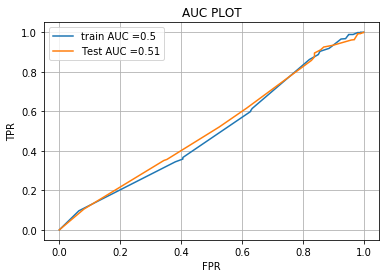

the maximum value of tpr*(1-fpr) 0.2250169656684473 for threshold 0.861
Train confusion matrix
[[ 74 128]
 [439 699]]
Test confusion matrix
[[ 38  61]
 [215 346]]


In [63]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
trainAUC, testAUC = SVM_validation (X_tr,y_train,X_te,y_test)

### 2.4.1 Applying SVM on BOW - Set 1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW),<font color='red'> SET 1</font>

model.best_estimator_ = SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
model.score = 0.85


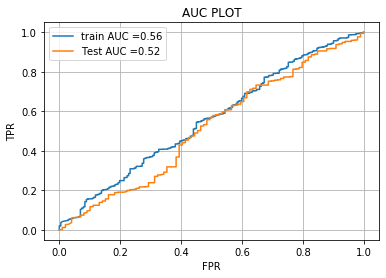

the maximum value of tpr*(1-fpr) 0.29937879552454366 for threshold 0.854
Train confusion matrix
[[111  91]
 [518 620]]
Test confusion matrix
[[ 51  48]
 [252 309]]


In [64]:
trainAUC_bow, testAUC_bow = SVM_validation (X_tr_bow,y_train,X_te_bow,y_test)

### 2.4.2 Applying SVM  on TFIDF Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_essay (TFIDF),<font color='red'> SET 2</font>

model.best_estimator_ = SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
model.score = 0.85


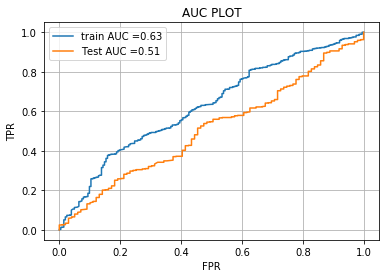

the maximum value of tpr*(1-fpr) 0.3455080130157128 for threshold 0.862
Train confusion matrix
[[146  56]
 [594 544]]
Test confusion matrix
[[ 58  41]
 [335 226]]


In [65]:
trainAUC_tfidf, testAUC_tfidf = SVM_validation (X_tr_tfidf,y_train,X_te_tfidf,y_test)

### 2.4.2 Applying SVM on TFIDF Avg W2V <font color='red'> SET 2</font>

In [ ]:
trainAUC_avg_w2v, testAUC_avg_w2v = SVM_validation (X_tr_tfidf_avg_w2v,y_train,X_te_tfidf_avg_w2v,y_test)

### 2.4.3 Applying SVM on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
trainAUC_avg_w2v, testAUC_avg_w2v = SVM_validation (X_tr_avg_w2v,y_train,X_te_avg_w2v,y_test)

### 2.4.4 Applying SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
trainAUC_tfidf_w2v, testAUC_tfidf_w2v = SVM_validation(X_tr_tfidf_w2v,y_train,X_te_tfidf_w2v,y_test)

### 2.4.2 Applying SVM  on TFIDF Set 5: categorical, numerical features <font color='red'> SET 5</font>

In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
trainAUA_set, testAUC_set = SVM_validation (X_tr_set5,y_train,X_te_set5,y_test)

## 2.5  Feature selection for Best Hyper Parameter /font>

In [ ]:
## 2.5.1 <font color='red'> Hyper Param-Analysis  <font color='blue'> categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW),<font color='red'> SET 1</font>

In [ ]:
bow_hyperparam= SVM_HyperParam_Analysis(X_tr_bow,y_train,X_te_bow,y_test)
print ("Hyper Param to apply is %s" % bow_hyperparam)

### 2.5.2 <font color='red'> Hyper Param -Analysis   <font color='blue'>  on TFIDF Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_essay (TFIDF),<font color='red'> SET 2</font>

In [ ]:
tfidf_hyperparam= SVM_HyperParam_Analysis(X_tr_tfidf,y_train,X_te_tfidf,y_test)
print ("Hyper Param to apply is %s" % tfidf_hyperparam)

### 2.5.3 <font color='red'> Hyper Parameter-Analysis     <font color='blue'>  on AVG W2V - categorical, numerical features + project_title(AVG W2V )+ preprocessed_essay (AVG W2V ),<font color='red'> SET 3</font>

In [ ]:
avgw2v_hyperparam= SVM_HyperParam_Analysis(X_tr_avg_w2v,y_train,X_te_avg_w2v,y_test)
print ("Hyper Param to apply is %s" % avgw2v_hyperparam)

### 2.5.3 <font color='red'> Hyper Parameter-Analysis     <font color='blue'>  on TFIDF W2V - categorical, numerical features + project_title(TFIDF W2V )+ preprocessed_essay (TFIDF W2V ),<font color='red'> SET 3</font>

In [ ]:
tfidfw2v_hyperparam= SVM_HyperParam_Analysis(X_tr_tfidf_w2v,y_train,X_te_tfidf_w2v,y_test)
print ("Hyper Param to apply is %s" % tfidfw2v_hyperparam)

### Hyper Param Analysis on TFIDF Set 5: categorical, numerical features + SET 5

### Logic Regression Analysis on Best Hyper Parameter

In [ ]:
set5_hyperparam = SVM_HyperParam_Analysis(X_tr_set5,y_train,X_te_set5,y_test)
print ("Hyper Param to apply is %s" % set5_hyperparam)

In [ ]:
tfidfw2v_hyperparam = SVM_HyperParam_Analysis(X_tr_tfidf_w2v,y_train,X_te_tfidf_w2v,y_test)

In [ ]:
HyperParameter = set5_hyperparam
trainAUC_analysis, testAUC_analysis = SVM_for_Best_Hyper_Parameter(X_tr_set5,y_train,X_te_set5,y_test,HyperParameter)

In [ ]:
HyperParameter =bow_hyperparam
trainAUC_bow_analysis, testAUC_bow_analysis =SVM_for_Best_Hyper_Parameter(X_tr_bow,y_train,X_te_bow,y_test, HyperParameter)

In [ ]:
HyperParameter = avgw2v_hyperparam
trainAUC_avg_w2v_analysis, testAUC_avg_w2v_analysis = SVM_for_Best_Hyper_Parameter(X_tr_avg_w2v,y_train,X_te_avg_w2v,y_test, HyperParameter)

In [ ]:
HyperParameter = tfidf_hyperparam
trainAUC_tfidf_analysis, testAUC_tfidf_analysis = SVM_for_Best_Hyper_Parameter(X_tr_tfidf,y_train,X_te_tfidf,y_test,HyperParameter)

In [ ]:
HyperParameter = tfidfw2v_hyperparam
trainAUC_tfidf_w2v_analysis, testAUC_tfidf_w2v_analysis = SVM_for_Best_Hyper_Parameter(X_tr_tfidf_w2v,y_train,X_te_tfidf_w2v,y_test,HyperParameter)

### 3.0 <font color='Blue'> Pretty Table  SET 3</font>

In [ ]:
#Draw Pretty Table using GridCVSearch

from prettytable import PrettyTable
    
LRTable = PrettyTable()

LRTable.field_names = ["Model Type", "Train AUC", "Test AUC"]
LRTable.add_row(["Regular", trainAUC, testAUC])
LRTable.add_row(["BoW", trainAUC_bow, testAUC_bow])
LRTable.add_row(["TFIDF", trainAUC_tfidf, testAUC_tfidf])
LRTable.add_row(["TFIDF_Avg_W2V", trainAUC_avg_w2v, testAUC_avg_w2v])
LRTable.add_row(["TFIDF_W2V", trainAUC_tfidf_w2v, testAUC_tfidf_w2v])
print (LRTable)

In [ ]:
#Draw Pretty Table using Best Analysis. Pretty table is drawn based on 
#best AUC is calcukated by passing varipus Hyperparameter in loop.

from prettytable import PrettyTable
    
LRTable = PrettyTable()

LRTable.field_names = ["Model Type", "Train AUC", "Test AUC"]
LRTable.add_row(["Regular_Analyis", trainAUC_analysis, testAUC_analysis])
LRTable.add_row(["BoW_Analysis", trainAUC_bow_analysis, testAUC_bow_analysis])
LRTable.add_row(["TFIDF_Analysis", trainAUC_tfidf, testAUC_tfidf])
LRTable.add_row(["TFIDF_Avg_W2V_Analysis", trainAUC_avg_w2v_analysis, testAUC_avg_w2v_analysis])
LRTable.add_row(["TFIDF_W2V_Analysis", trainAUC_tfidf_w2v_analysis, testAUC_tfidf_w2v_analysis])
print (LRTable)

<h1>3. Conclusions</h1>

Logistic Regression is a stastical method for analyzing a dataset in which there are one or more independent variables that determine the outcome. 

## Summary of above program as below:

Lot of plots are drawn for different data set between train and test data. Test data is very near to train data.
Please see pretty table for all comparasions.

### Step 1: Import the necessary Libraries
we will need to import libraries that allow for data analysis and data visualization to get acclimated to the dataset. We will be using pandas, numpy, matplotlib and seaborn to conduct this. Data Exploration libraries

### Step 2: Read in the dataset.
We will use the pandas .read_csv() method to read in the dataset. Then we will use the. head() method to observe the first few rows of the data, to understand the information better. In our case, the feature(column) headers tell us pretty little. This is fine because we are merely trying to gain insight via classifying new data points by referencing it’s neighboring elements.

### Step 3: Standardize (normalize) the data scale to prep for Logistic regression.
Because the distance between pairs of points plays a critical part on the classification, it is necessary to normalize the data This will generate an array of values. 

### Step 4: Split the normalized data into training and test sets.
This step is required to prepare us for the fitting (i.e. training) the model later. The “X” variable is a collection of all the features. The “y” variable is the target label which specifies the classification of 1 or 0 based. Our goal will be to identify which category the new data point should fall into.


### Step 5: Create and Train the Model.
Here we create a Logistic Regression Object and use the .fit() method to train the model. Upon completion of the model we should receive confirmation that the training has been complete

Please see functions as covered below, used in above program: def SVM_validation(X,y): def 

### Step 6: Make Predictions.
Here we review where our model was accurate and where it misclassified elements.

Please see functions as covered below, used in above program: def SVM_validation(X,y):

### Step 7: Evaluate the predictions.

Evaluate the Model by reviewing the classification report or confusion matrix. By reviewing these tables, we are able to evaluate how accurate our model is with new values.

def SVM_validation(X,y):

### Setp 8:Classification Report :
This tells us our model was around 84% accurate… Print out classification report and confusion matrix

I have covered various set to show confusion matrix.

Please see section 2. covered various data sets and created confusion matrix.

### Step 9: Evaluate alternative Hyper Parameter for better predictions.
To simplify the process of evaluating multiple cases of Alpha values, we create a function to derive the error using the average where our predictions were not equal to the test values.

Please see section 2. covered various data sets and created error accuracy reports.

### Step 10: Adjust Hyper Parameter value per error rate evaluations 
This is just fine tuning our model to increase accuracy. We will need to retrain our model with the new Alpha.
Please see section 3 in above program. we have created confusion matrix for optimal Alpha value for various data sets. As we can see for optimal Alpha, Accuracy is much higher - so prediction is much better.



In [ ]:







+